In [155]:
import os

import numpy as np
import pandas

import matplotlib.pyplot as plt


from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cross_validation import KFold

from scipy.stats.mstats import zscore

In [156]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

function for flexible data frame loading

In [157]:
def get_data_from_tsv(feature_file, x_fields, y_field, x_filter=None, 
                      seed=0, shuffle=False, train_portion=0.6, test_portion=0.2, verbose=True):

    # Load the dataset
    my_data = pandas.read_csv(feature_file)

    # Drop missing values
    print("original data shape: ", my_data.shape)
    for predictor in x_fields:
        if verbose:
            print("removing NANs ... deleted rows  : ", my_data[my_data[predictor].isnull()])
        my_data = my_data.dropna(subset=[predictor])
        my_data = my_data.reset_index(drop=True)
    print("removing NANs ... new data shape: ", my_data.shape)
    
    # Filter responses if len(x_filter) > 0
    if verbose:
        print(x_filter)
    if not x_filter == None:
        for ff in x_filter:
            my_data = my_data.loc[my_data[ff[0]].isin(ff[1:])]
            if verbose:
                print("filtering %s by " % ff[0], ff[1:], "num datapoints left: ", len(my_data))
        my_data = my_data.reset_index(drop=True)
    labels = my_data['word']
    
    # Choose the coefficients
    if type(x_fields[0]) == str:
        x_fields.append(y_field)
        my_data = my_data[x_fields]
    else:
        x_fields.append(my_data.columns.get_loc(y_field))
        my_data = my_data.iloc[:,x_fields]
    del x_fields[-1]
    if verbose:
        print("selected coefficients... new data shape: ", my_data.shape)
    
    # Split the data into training/testing sets
    x_train, y_train, x_dev, y_dev, x_test, y_test = train_validate_test_split(my_data, 
                                                                               y_field,
                                                                               train_percent=train_portion,
                                                                               validate_percent=test_portion,
                                                                               seed=seed,
                                                                               shuffle=shuffle)

    return x_train, y_train, x_dev, y_dev, x_test, y_test, labels




function for train / dev / test splitting

In [158]:
def train_validate_test_split(df, y, train_percent=.6, validate_percent=.2, seed=0, shuffle=True):
    np.random.seed(seed)
    
    if shuffle:
        perm = np.random.permutation(df.index)
    else:
        perm = df.index

    train_end    = int(train_percent * len(df))
    validate_end = int(validate_percent * len(df)) + train_end

    
    x_train        = df.iloc[perm[:train_end]]
    x_validate     = df.iloc[perm[train_end:validate_end]]
    x_test         = df.iloc[perm[validate_end:]]
        
    y_train    = x_train[y]
    y_validate = x_validate[y]
    y_test     = x_test[y]
    
    x_train = x_train.drop(y, axis=1)
    x_validate = x_validate.drop(y, axis=1)
    x_test = x_test.drop(y, axis=1)

    return x_train, y_train, x_validate, y_validate, x_test, y_test




Function to do Ridge Regression with 10-fold cross validation

In [159]:
def ridge_cv(x, y, model, method_name, n_folds=10):

    kf = KFold(len(x), n_folds=n_folds, shuffle=True, random_state=0)

    cv_mse    = 0.0
    cv_expvar = 0.0
    
    # collect scores from n-fold cross validation
    for train,test in kf:

        model.fit(x[train], y[train])
        y_pr        = model.predict(x[test])
        this_mse    = np.mean((y_pr - y[test]) ** 2)
        this_expvar = model.score(x[train], y[train])
        
        cv_mse    += this_mse
        cv_expvar += this_expvar

    # compute train-fit, too
    model.fit(x,y)
    y_pr         = model.predict(x)
    train_mse    = np.mean((y_pr - y) ** 2)
    train_expvar = model.score(x, y)
    
    print('Method              : %s  ' %method_name)
    print('MSE    on training  : %.4f' %train_mse)
    print('MSE    on 10-fold CV: %.4f' %(cv_mse / float(n_folds)))
    print('ExpVar on training  : %.4f' %train_expvar)
    print('ExpVar on 10-fold CV: %.4f' %(cv_expvar / float(n_folds)))
    
    return model


Function for plotting data points and fit regression line

In [160]:
def plot(x, y, regression, labels=[]):
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Data')
    ax.scatter(x, y)

    ax.plot(x, regression, label='regression line', lw=2.)
    
    if len(labels) == len(x):
        for ll, x, y in zip(labels, x, y):
            plt.annotate(
                ll,
                fontsize=4,
                xy=(x, y), xytext=(0, 1),
                textcoords='offset points', ha='right', va='bottom')

    plt.legend(loc=0)
    fig.show()

Select corpus
- Brent 
- Providence

Select feature set
- avg_prosody (=egemaps features) 
- srilm (=language model-based features))

Specify word filter, selecting groups of target words go look at
 - e.g., filter by pos=noun

Specify predictor set
 - for various subsets of our data sets (e.g., only consider words of a specific POS)

Specify subset of selected predictors which should be log-transformed

In [161]:

word_filter        = None
all_predictors     = [['freq'], 
                      ['freq','w1'], 
                      ['freq','w1w2'], 
                      ['freq','p0w1'],
                      ['freq','p0w1w2'],
                      ['freq','p0p1w1'],
                      ['freq','p0p1w1w2'],
                      ['freq','w1','w1w2','p0w1','p0w1w2','p0p1w1','p0p1w1w2']]
all_log_predictors = all_predictors

feature_file   = os.path.join("/home/lea/postdoc/projects/cogsci/data/childes", 
                              corpus, 
                              "features",
                              feature_set+".csv")


Do Ridge regression for all predictor sets as defined above



 ['freq']
original data shape:  (364, 12)
removing NANs ... new data shape:  (364, 12)
Method              : Linear Regression  
MSE    on training  : 0.8762
MSE    on 10-fold CV: 0.8866
ExpVar on training  : 0.1238
ExpVar on 10-fold CV: 0.1240


/usr/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


intercept 7.75550523809e-16
0 -0.351886654108 freq


 ['freq', 'w1']
original data shape:  (364, 12)
removing NANs ... new data shape:  (339, 12)
Method              : Linear Regression  
MSE    on training  : 0.9092
MSE    on 10-fold CV: 0.9237
ExpVar on training  : 0.0908
ExpVar on 10-fold CV: 0.0914
intercept -1.28280506032e-16
0 -0.255435345637 freq
1 -0.0635513005205 w1


 ['freq', 'w1w2']
original data shape:  (364, 12)
removing NANs ... new data shape:  (339, 12)
Method              : Linear Regression  
MSE    on training  : 0.9091
MSE    on 10-fold CV: 0.9191
ExpVar on training  : 0.0909
ExpVar on 10-fold CV: 0.0913
intercept -1.0264653382e-16
0 -0.26129432821 freq
1 -0.0611306463614 w1w2


 ['freq', 'p0w1']
original data shape:  (364, 12)
removing NANs ... new data shape:  (339, 12)
Method              : Linear Regression  
MSE    on training  : 0.9090
MSE    on 10-fold CV: 0.9238
ExpVar on training  : 0.0910
ExpVar on 10-fold CV: 0.0917
intercept -9.67999065154e-17
0 -0.2545

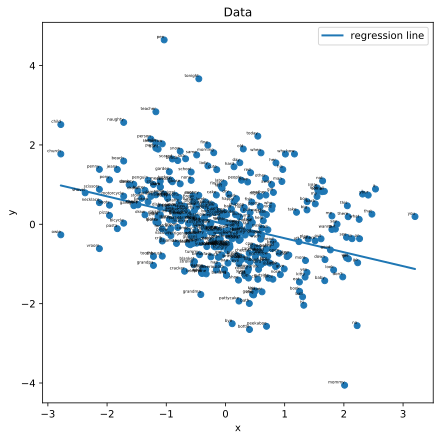

In [164]:
# Load the data with the given selectors
for idx, predictors in enumerate(all_predictors):
    
    print("\n\n", predictors)
    
    train_portion = 1.0 # because we do cross-validation
    x_train, y_train, _, _, _, _, labels = get_data_from_tsv(feature_file, 
                                                             x_fields     = predictors, 
                                                             y_field      = 'y', 
                                                             x_filter     = word_filter,
                                                             train_portion= train_portion,
                                                             verbose=False)
    
    # Take the log of some of our features if desired
    for predictor in all_log_predictors[idx]:
        idx = x_train.columns.get_loc(predictor)
        x_train.iloc[:,idx] = np.log(x_train.iloc[:,idx])
        
        
    # Scale features and response (returns a numpy array)
    x_array = preprocessing.scale(x_train)
    y_array = preprocessing.scale(y_train)

    x_train = pandas.DataFrame(x_array, columns=x_train.columns, index=x_train.index)
    y_train = pandas.DataFrame(y_array)
    
    # Train a Ridge Regression model, using CV to find best alpha (regularization weight) and 10-fold cross validaton over data
    # model = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], normalize=False)
    model  = linear_model.LinearRegression()


    regr1 = ridge_cv(x_array,
                     y_array, 
                     model,
                     "Linear Regression",
                     n_folds=10)

    if len(predictors) == 1:
        plot(x_array, y_array, model.predict(x_array), labels=labels)
    
    # Print the regression coefficients
    print("intercept", regr1.intercept_)
    for i,l in enumerate(x_train.columns):
        print(i, regr1.coef_[i], l)
